In [31]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ast
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

import warnings; warnings.simplefilter('ignore')

# Clean Revenue and Budget

In [32]:
md = pd. read_csv('../data/movies_metadata.csv')
nsfw_data = pd.read_csv('../data/nsfw_score.csv')
credits = pd.read_csv('../data/credits.csv')
keywords = pd.read_csv('../data/keywords.csv')
nsfw_data.columns = ['id', 'nsfw_score']
#Converting both fields to the same data type
md['id'] = md['id'].astype(str)
nsfw_data['id'] = nsfw_data['id'].astype(str)
credits['id'] = credits['id'].astype(str)
md = md.merge(nsfw_data, on='id', how='left')
md = md.merge(credits, on='id', how='left')

In [33]:
md = (md.drop(['budget'], axis=1)
         .join(md['budget'].apply(pd.to_numeric, errors='coerce')))

md = md[md['budget'].notnull()]

In [34]:
md = md.replace(0,'NaN')
md = md[md.budget.notnull()]
md = md[md.budget != 'NaN']
md.loc[:, 'budget'] = pd.to_numeric(md['budget'])
md = md[md['budget'] != 0]
md = md[md['revenue'].notnull()]
md = md[md['revenue'] != 'NaN']

# Clean Genres and Production Companies

In [35]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [36]:
md['production_companies'] = md['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

## Add Language Features as Integer

In [37]:
md["Eng"] = md["original_language"] == 'en'
md["Eng"] = md["Eng"].astype(int)

In [38]:
md.belongs_to_collection[md.belongs_to_collection.notnull()] = 1
md.belongs_to_collection[md.belongs_to_collection.isnull()] = 0

### Franchise Movies

In [74]:
franchise_df = md[md['belongs_to_collection'] == 1]
non_franchise_df = md[md['belongs_to_collection'] == 0]

In [73]:
franchise_df.sort_values('revenue',ascending = False)[['title','revenue','belongs_to_collection']].head(10)

,title,revenue,belongs_to_collection
14580,Avatar,2.78797e+09,1
26617,Star Wars: The Force Awakens,2.06822e+09,1
17854,The Avengers,1.51956e+09,1
25132,Jurassic World,1.51353e+09,1
28893,Furious 7,1.50625e+09,1
26620,Avengers: Age of Ultron,1.4054e+09,1
17473,Harry Potter and the Deathly Hallows: Part 2,1.342e+09,1
22153,Frozen,1.27422e+09,1
43328,The Fate of the Furious,1.23876e+09,1
20868,Iron Man 3,1.21544e+09,1


In [82]:
print(franchise_df['revenue'].mean())

print(non_franchise_df['revenue'].mean())

195243737.166
59257153.9083


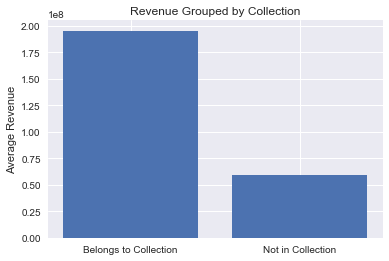

In [99]:
yCols = ['Belongs to Collection', 'Not in Collection']
xCols = [franchise_df['revenue'].mean(),non_franchise_df['revenue'].mean()]
y = np.arange(len(yCols))
plt.bar(y, xCols,align = 'center')
plt.xticks(y,yCols)
plt.ylabel("Average Revenue")
plt.title("Revenue Grouped by Collection")

### Genres

In [108]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [112]:
gen_df = md.drop('genres', axis=1).join(s)

In [113]:
gen_df['genre'].value_counts().shape[0]

20

In [114]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,2595
1,Comedy,1854
2,Thriller,1508
3,Action,1417
4,Romance,1019
5,Adventure,966
6,Crime,864
7,Science Fiction,637
8,Horror,586
9,Family,536


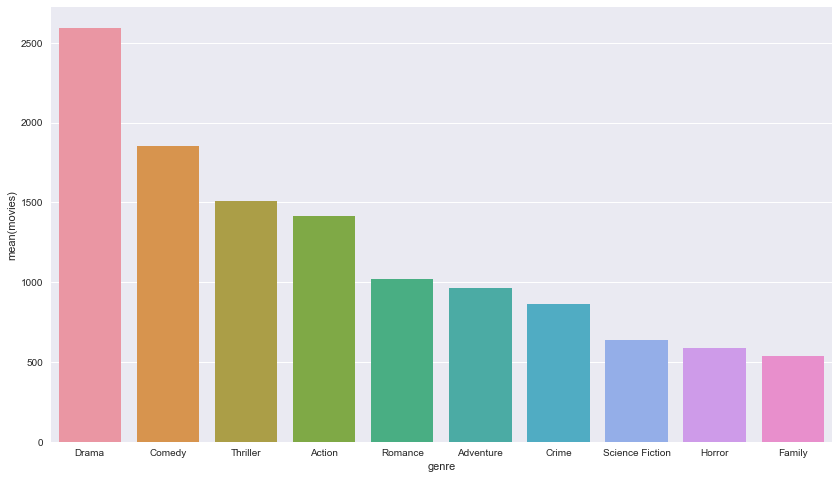

In [117]:
plt.figure(figsize=(14,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(10))
plt.show()

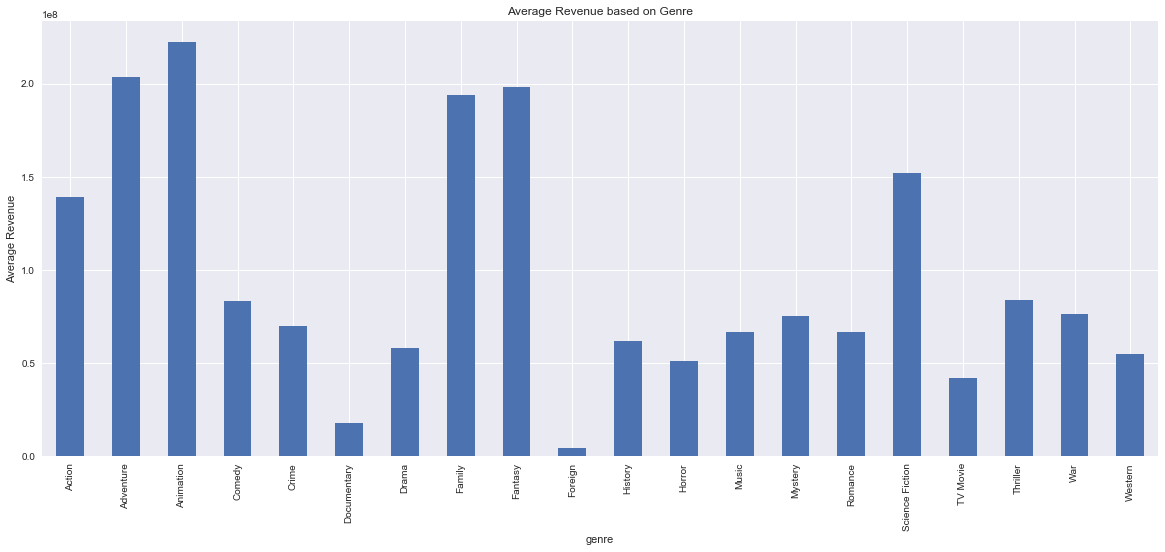

In [140]:
plt.figure(figsize=(20,8))
gen_df.revenue = gen_df.revenue.astype(float)
gen_df[gen_df.genre.notnull()].groupby('genre').revenue.mean().plot(kind='bar')
plt.ylabel('Average Revenue')
plt.title('Average Revenue based on Genre')

### Cast and Crew Size

In [146]:
md['cast'] = md['cast'].apply(literal_eval)
md['crew'] = md['crew'].apply(literal_eval)
md['cast_size'] = md['cast'].apply(lambda x: len(x))
md['crew_size'] = md['crew'].apply(lambda x: len(x))
md = md.drop(['cast','crew'], axis = 1)

In [156]:
md['ROI'] = md['revenue'] - md['budget']

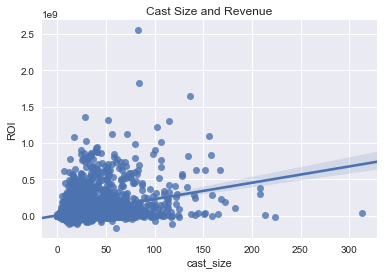

In [157]:
sns.regplot(x='cast_size',y='ROI',data = md)
plt.title('Cast Size and Revenue')

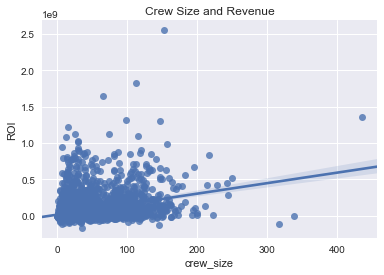

In [158]:
sns.regplot(x='crew_size',y='ROI',data = md)
plt.title('Crew Size and Revenue')

In [163]:
md.sort_values('cast_size', ascending = False)[['title','revenue','cast_size']].head()

,title,revenue,cast_size
927,Around the World in Eighty Days,4.2e+07,313
19135,Rock of Ages,5.94186e+07,224
929,Mr. Smith Goes to Washington,9.6e+06,213
39358,Jason Bourne,4.15485e+08,208
20100,Les Misérables,4.4181e+08,208


### Production Companies Analysis

In [166]:
s = md.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

In [171]:
com_df = md.drop('production_companies', axis=1).join(s)
com_df.revenue = com_df.revenue.astype('float')

In [172]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

In [173]:
com_pivot.sort_values('Total', ascending=False).head(10)

,Total,Average,Number
Warner Bros.,6.136088e+10,1.467964e+08,418
Universal Pictures,5.310507e+10,1.375779e+08,386
Paramount Pictures,4.737976e+10,1.377319e+08,344
Twentieth Century Fox Film Corporation,4.627489e+10,1.563341e+08,296
Walt Disney Pictures,4.033436e+10,3.055633e+08,132
Columbia Pictures,3.160289e+10,1.504899e+08,210
New Line Cinema,2.170645e+10,1.247497e+08,174
Amblin Entertainment,1.695835e+10,2.975149e+08,57
DreamWorks SKG,1.543413e+10,2.004433e+08,77
Dune Entertainment,1.481700e+10,2.511355e+08,59


In [175]:
com_pivot.sort_values('Total', ascending=True).head(10)

,Total,Average,Number
An Erich von Stroheim Production,1.0,1.0,1
Comet Film Produktion GmbH,1.0,1.0,1
Cinema West Films,1.0,1.0,1
Avrora Media,1.0,1.0,1
Cobblestone Pictures,1.0,1.0,1
People Tree Films,2.0,2.0,1
A.F. Cinema e Vídeo,3.0,3.0,1
Инвада фильм,3.0,3.0,1
Кинокомпания «Lunapark»,3.0,3.0,1
Penta Entertainment,4.0,4.0,1


In [178]:
com_pivot.sort_values('Total', ascending=False).head(10).Total.sum()/com_pivot.Total.sum()

0.21276366309964953

In [179]:
com_pivot.shape[0]

5437

In [9]:
md = md.drop(['title', 'original_title', 'overview', 'tagline', 'original_title','original_language','poster_path','homepage','id','imdb_id','popularity','vote_count', 'adult', 'status', 'video', 'vote_average','spoken_languages'], axis=1);

In [10]:
diff_genres = set()
for x in md.genres:
    for y in x:
        diff_genres.add(y)

In [11]:
for genre in diff_genres:
    md['is_' + str(genre)] = md['genres'].apply(lambda x: 1 if genre in x else 0)
md = md.drop('genres', axis=1)

In [12]:
md['production_countries'] = md['production_countries'].apply(lambda x: len(x))
md['production_companies'] = md['production_companies'].apply(lambda x: len(x))

In [13]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [14]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [15]:
md['month'] = md['release_date'].apply(get_month)

In [16]:
for month in month_order:
    md['release_' + str(month)] = md['month'].apply(lambda x: 1 if month in x else 0)
md = md.drop(['release_date', 'month'], axis =1);

In [18]:
#Adding profit column
md['profit'] = md['revenue'] >= md['budget']
md.loc[:, 'profit'] = md['profit'].astype(int)
md = md.drop(['budget', 'revenue'], axis=1)

In [19]:
md = md[md['runtime'] != 'NaN']
md = md[md['runtime'].notnull()]

In [20]:
md["belongs_to_collection"] = md["belongs_to_collection"].astype(int)
md["runtime"] = md["runtime"].astype(int)

In [21]:
X = md.loc[:, 'belongs_to_collection':'crew_size']

In [22]:
y = md['profit']

In [ ]:
fran_pivot = df_fran.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

In [29]:
param_test = {
 'min_child_weight':[3,4,5,6,7]}

ind_params = {'n_estimators': 100, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic','nthread':16, 'max_depth' :5,
             'learning_rate':0.1, 'subsample':0.5, 'min_child_weight':3,
             'gamma':0}

def doGridCV(X,y):
    opt_xgb = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                                param_test, 
                                scoring = 'accuracy', cv = 3, n_jobs= -1)
    opt_xgb.fit(X, y)
    print(opt_xgb.best_params_, opt_xgb.best_score_)


0.703566121842


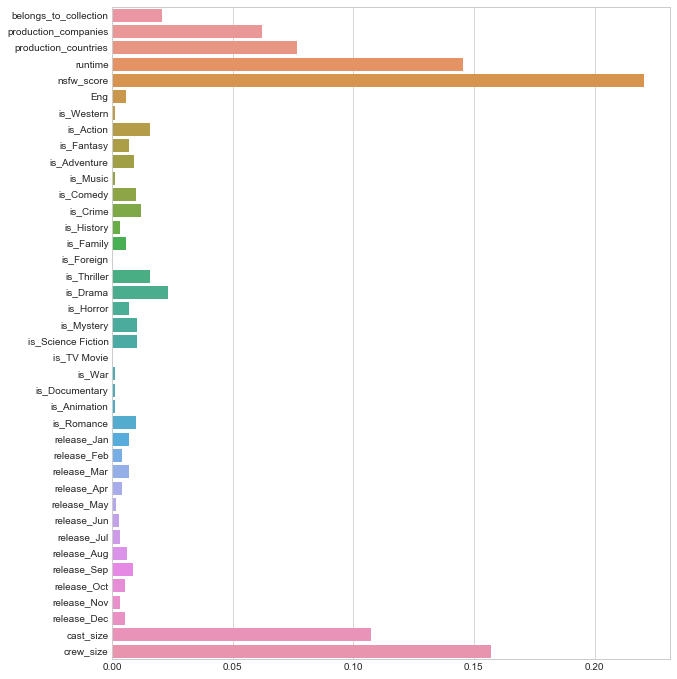

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=0)
model = xgb.XGBClassifier(**ind_params)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=model.feature_importances_, y=X.columns)